# Description
This notebook looks at some simple statistics of histortical intraday equity data. First we look at midprice and microprice, then order imbalance, stamped every 100 millisecond of the trading day. We will see that order imbalance tends to mean-revert, and has siginificant auto-correlation. Next, we look at the behaviour of order imbalance an instant before market order buys or sells arrive. The interesting aspect of this is that buy orders tend to arrive when the order imbalance is tilted to the buy side, while sell orders tend to arrive when the order imbalance is tilted to the sell side.

In [8]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)



# load data

In [9]:
data = sio.loadmat('../data/MSFT_20141103.mat')

In [10]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

# Midprice, Microprice and Spread

Let $P^b_t$ and $P_t^a$ denote the best bid and ask prices, and $V_t^b$ and $V_t^a$ denote the volume posted at the best bid and ask. Then,

$$midprice_t=\tfrac{1}{2}(P^b_t+P^a_t)$$

$$microprice_t=\frac{P^b_t\,V^a_t+P^a_t\,V^b_t}{V^a_t+V^b_t}$$

$$spread_t=P_t^a-P_t^b$$

In [11]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

plot microprice

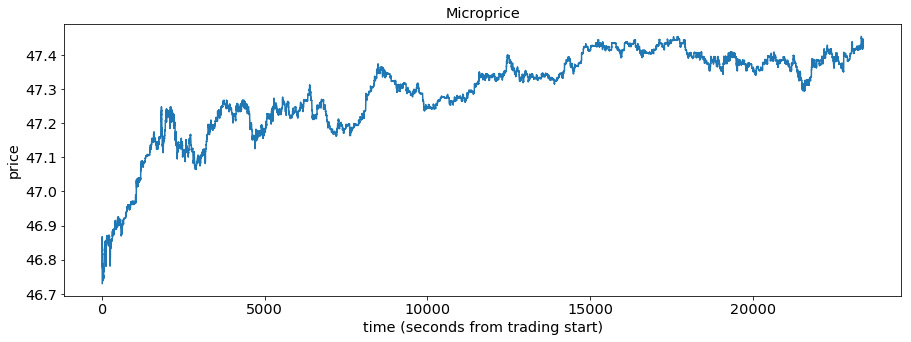

In [12]:
plt.plot(t, microprice)
plt.title('Microprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

plot the difference between micro and mid prices

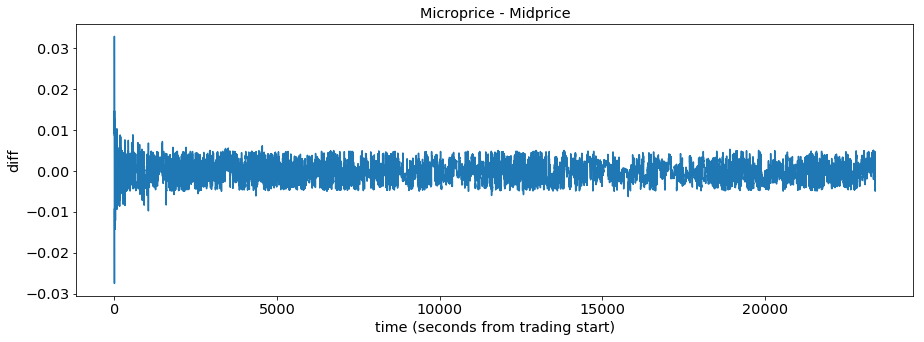

In [13]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

Note that the difference is typically in the range $[-0.01, 0.01]$ while at the beginning of the day it is three times as large.

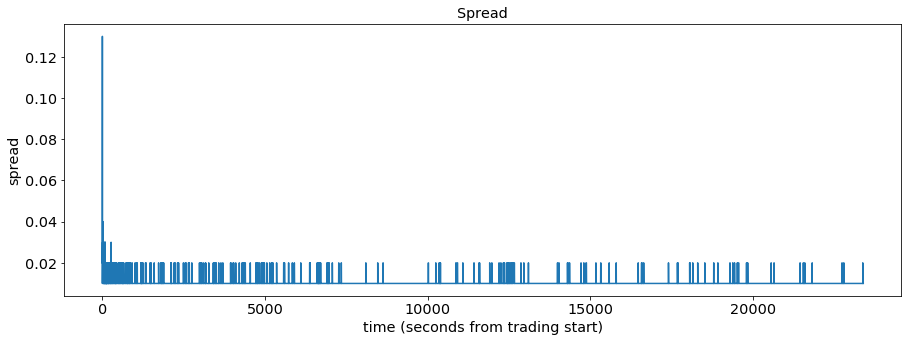

In [14]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.show()

This plot shows that the spread is about 0.13 in the morning, but quickly drops to 0.01 but sometimes spikes to 0.02 (mostly in the morning).

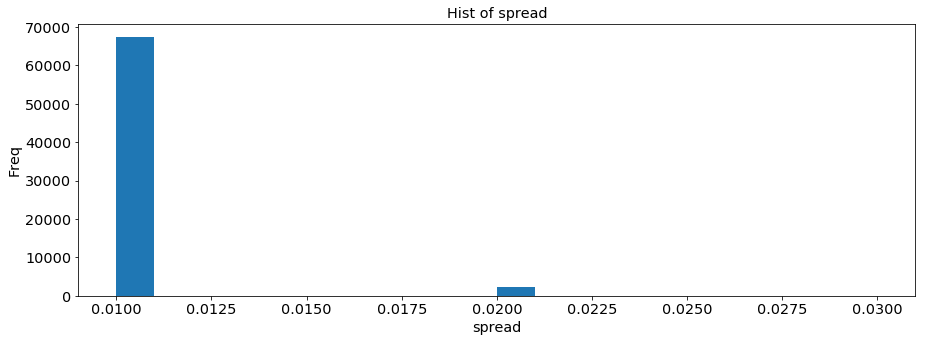

In [15]:
plt.hist(spread,bins=[0.01,0.02,0.03], width=0.001,align='mid') 
plt.title("Hist of spread")
plt.xlabel(r'spread')
plt.ylabel('Freq')
plt.show()

# Volume Imbalance
Now, let us look at how volume imbalance at the best bid and ask varies through the day
$$\rho_t=\frac{V_t^b-V_t^a}{V_t^b+V_t^a}\in(-1,1)$$

In [16]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

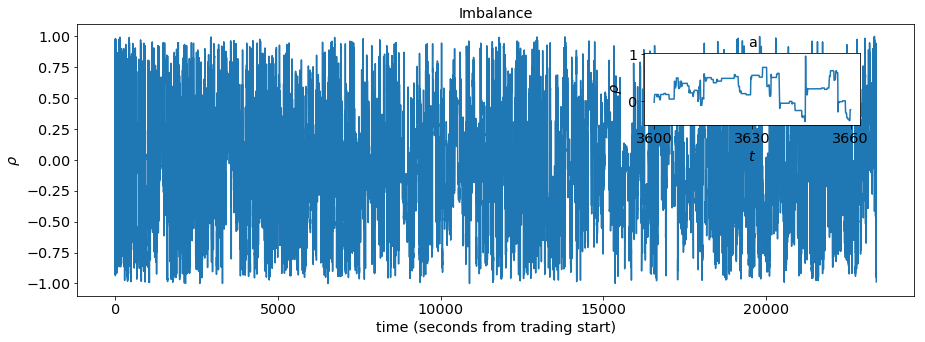

In [10]:
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

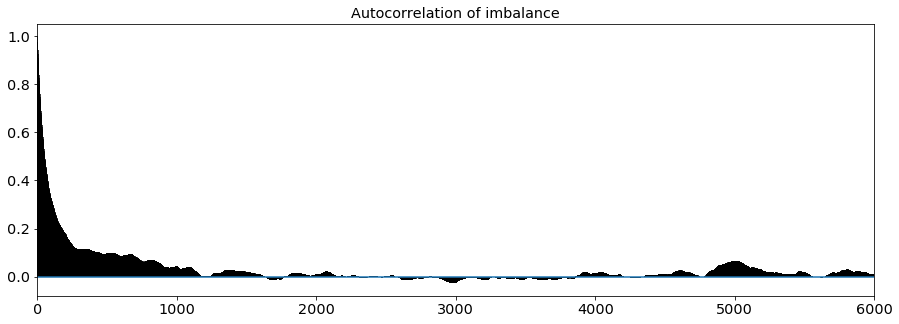

In [11]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,6000])
plt.show()

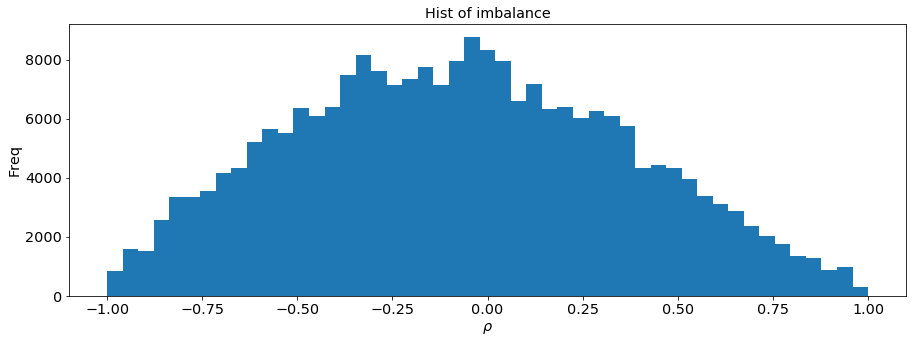

In [12]:
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

The raw imbalance

In [13]:
## transform imbalance using logit
y = -np.log(2/(1+rho)-1)

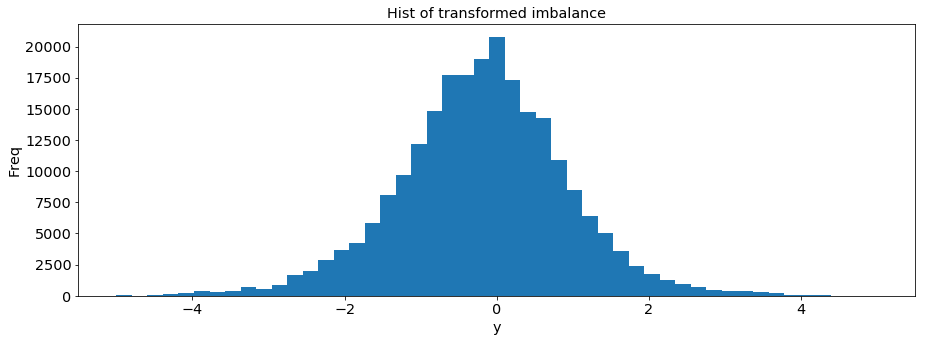

In [14]:
plt.hist(y, bins=np.linspace(-5, 5, num=50)) 
plt.title("Hist of transformed imbalance")
plt.xlabel('y')
plt.ylabel('Freq')
plt.show()

# Volume Imbalance at times of Market Orders

In [15]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

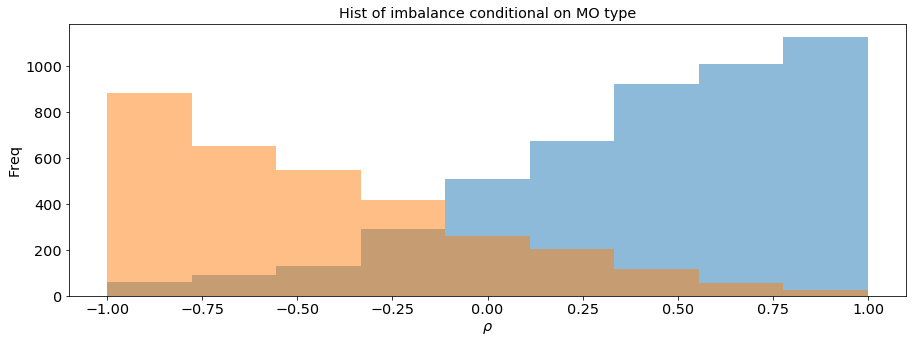

In [16]:
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of imbalance conditional on MO type")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

In [17]:
# determine the rate of arrival of market orders conditional on order arrival in a specific bin 
def MOActivity(MO,rho,a,b):
    idx_rho = (rho>=a) & (rho<b)
    idx_rho_MO = (rho_MO>=a) & (rho_MO<b)
    idx_rho_MO_b = idx_rho_MO & (MO[:,7]==-1)
    idx_rho_MO_s = idx_rho_MO & (MO[:,7]==+1)
    
    return [np.sum(idx_rho_MO_b), np.sum(idx_rho_MO_s)]/(dt*np.sum(idx_rho))

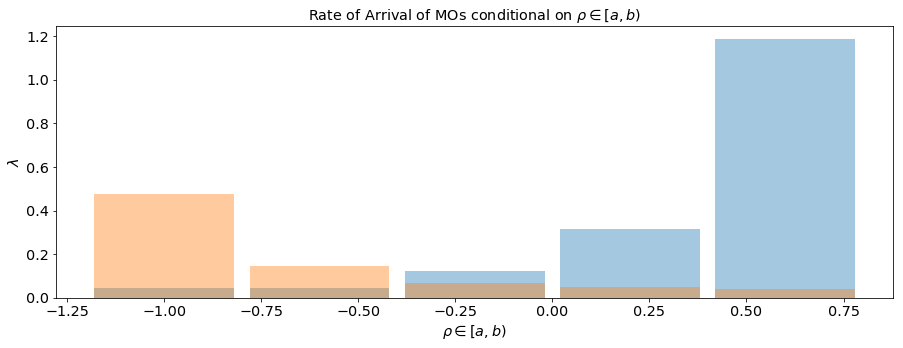

In [18]:
nbands=5
bands = np.array([-1+2*x/(nbands) for x in range(nbands+1)])

MO_activity=np.zeros((nbands,2))
for i in range(nbands):
    MO_activity[i,:] = MOActivity(MO,rho,bands[i],bands[i+1])
MO_activity=MO_activity.T

plt.bar(bands[0:nbands],MO_activity[0,:],width=[(bands[j+1]-bands[j])*0.9 for j in range(nbands)],alpha=0.4)
plt.bar(bands[0:nbands],MO_activity[1,:],width=[(bands[j+1]-bands[j])*0.9 for j in range(nbands)],alpha=0.4)
plt.title(r'Rate of Arrival of MOs conditional on $\rho\in[a,b)$')
plt.xlabel(r'$\rho\in[a,b)$')
plt.ylabel(r'$\lambda$')
plt.show()

In [19]:
def GenerateRhoTransition(rho,bands):
    rho_band = np.zeros((rho.size,1))

    for i in range(bands.size-1):
        idx_i = (rho>=bands[i]) & (rho<bands[i+1])
        rho_band[idx_i]=i

    rho_A = np.zeros((bands.size-1,bands.size-1))
    norm = np.zeros(bands.size-1)
    for i in range(bands.size-1):

        idx_i = (rho_band==i)

        idx_ip1 = idx_i
        idx_ip1[1:idx_i.size-1] = idx_i[0:idx_i.size-2]

        for j in range(bands.size-1):
            rho_A[i][j] = np.sum( rho_band[idx_ip1]==j )
            norm[i]+=rho_A[i][j]

        for j in range(bands.size-1):
                rho_A[i][j] /=norm[i]
                
    return rho_A

In [20]:
rho_A = GenerateRhoTransition(rho,bands)

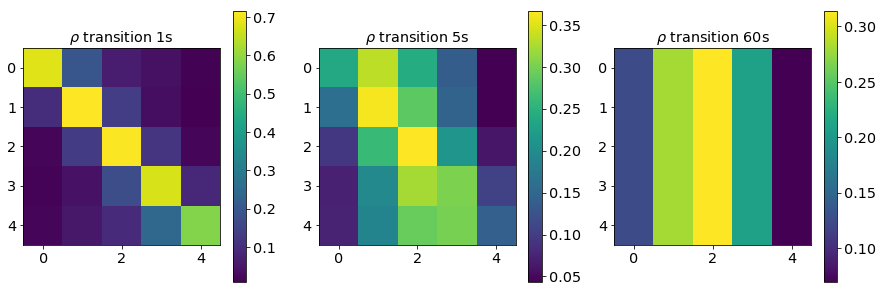

In [22]:
fig, axarr = plt.subplots(1,3)
im = axarr[0].imshow(np.linalg.matrix_power(rho_A,int(np.round(1/dt))))
axarr[0].set_title(r'$\rho$ transition 1s')
fig.colorbar(im, ax=axarr[0])

im=axarr[1].imshow(np.linalg.matrix_power(rho_A,int(np.round(5/dt))))
axarr[1].set_title(r'$\rho$ transition 5s')
fig.colorbar(im, ax=axarr[1])

im=axarr[2].imshow(np.linalg.matrix_power(rho_A,int(np.round(60/dt))))
axarr[2].set_title(r'$\rho$ transition 60s')
fig.colorbar(im, ax=axarr[2])

plt.show()